## Importing Libraries

In [2]:
# Output of plotting commands is displayed directly below the code cell that produced it
%matplotlib inline

# To eliminate warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Keras via TensorFlow
import tensorflow as tf
from tensorflow import keras

# Importing Numpy for handling numpy
import numpy as np

# Importing Matplotlib to plot
import matplotlib.pyplot as plt

# TQDM to see the progress
from tqdm import tqdm

# To display output in Jupyter Notebook
from IPython import display

# Enable eager execution to immediately evaluate operations, without building graphs
    # If Tensorflow 2.x is used, comment this line
#tf.enable_eager_execution()

## Load and Visualize the data

In [3]:
# Loading data from Fashion MNIST dataset (available as built-in database in tf.keras)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# Normalizing training dataset
x_train = x_train.astype(np.float32)/255.0

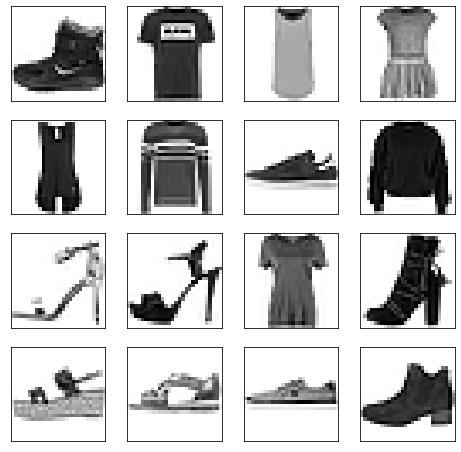

In [5]:
# Fixing plot size for 4x4 matrix of images
plt.figure(figsize=(8,8))
# Plotting 16 random training images as 4x4 matrix
for i in range(16) :
    plt.subplot(4, 4, i+1)
    # cmap - maps numbers to colours based on colormap specified - Here Binary colormap is used
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    # X and Y ticks are set empty
    plt.xticks([])
    plt.yticks([])
# Display the plot in console
plt.show()

## Splitting training data into batches

In [6]:
# Reshaping to match with dims of generated image from noise 
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
print(x_train_dcgan.shape)

# 32 images will be grouped as one batch from training dataset
batch_size = 32
# from_tensor_slices - creates dataset with seperate element for each row
# from_tensors - combines the input and returns dataset as single element

# shuffle - Randomly sample from input - can hold items of buffersize mentioned
    # An item is randomly picked from 1000 items in buffer and next item from source dataset will be loaded into buffer
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
# Last (Incomplete) batch removed
# When a data is being processed, next data is fetched from dataset synchronously - Reduces time
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

(60000, 28, 28, 1)


## Build the Generator Network for DCGAN

In [7]:
num_features = 100

# Creating Generator Neural Network
generator = keras.models.Sequential([
    # If dense layer is first layer of model, need to specify input shape. else, should not
    keras.layers.Dense(7*7*128, input_shape = [num_features]),
    # Reshaping to make sure size is as required
    keras.layers.Reshape([7,7,128]),
    # Performing Batch Normalization for easing out computations
    keras.layers.BatchNormalization(),
    
    # Performing Transpose convolution to convert small input(noise) to larger input(image)
        # selu (Scaled Exponential Linear Unit) activation is more efficient for GANs
        # 'same' padding tries to pad data in balanced fashion on either sides
        # Convolution layers perform the core operation involving features
    
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding = 'same', activation = 'selu'),
    # Performing Batch Normalization for easing out computations
    keras.layers.BatchNormalization(),
    
    # Performing Transpose convolution at final layer - tanh activation used in final layer
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'same', activation = 'tanh' )
])

## Build the Discriminator Network for DCGAN

In [8]:
# Creating Discriminator Neural Network
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding = 'same', input_shape = [28,28,1]),
    keras.layers.LeakyReLU(0.2), # Activation function
    keras.layers.Dropout(0.3), # Dropping 30 percent of neurons to acoid overfit
    
    keras.layers.Conv2D(128, (5,5), (2,2), padding = 'same'),
    keras.layers.LeakyReLU(0.2), # Activation function
    keras.layers.Dropout(0.3), # Dropping 30 percent of neurons to acoid overfit   
    
    keras.layers.Flatten(), # Flatten the layer to feed into final layer
    # Since discriminator performs binary classification, sigmoid activation is used in final layer
    keras.layers.Dense(1, activation = 'sigmoid')   
])

# Compiling Discriminator
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
# First we need to train only generator
discriminator.trainable = False

## Compile DCGAN

In [9]:
# Creating and compiling GAN
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

## Training procedure for DCGAN

In [10]:
# Generating random noise to serve as test_noise_input for Generator model
seed = tf.random.normal(shape = [batch_size, num_features])

In [11]:
# Defining function to train GAN
def train_dcgan(gan, dataset, batch_size, num_features, total_epochs = 10):
    # Getting generator and discriminator from GAN
    generator, discriminator = gan.layers
    for epoch in tqdm(range(total_epochs)):
        print("Epoch {} out of {} epochs" .format(epoch+1, total_epochs))
        for x_batch in dataset:
            # For each epoch, 
                # For each batch in dataset
                    #random noise is converted into a realistic Fashion MNIST image using trained generator
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_images = generator(noise)
            # "Realistic" and "Real" images are concatenated for to be fed as input to discriminator
            disc_input = tf.concat([generated_images, x_batch], axis = 0)
            # Training discriminator on current batch
                # Creating output labels for discriminator
            disc_labels = tf.constant( [[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(disc_input, disc_labels)
            # Training generator on current batch
                # Creating output labels for generator
            gen_labels = tf.constant( [[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, gen_labels)
        # To clear previous output (if new output is available to be replaced)
        display.clear_output(wait = True)
        # Calling custom function to display the generated images at the end of every epoch
        generate_images(generator, epoch+1, seed)
            
        

In [12]:
# Custom function to display the generated images
def generate_images(model, epoch, test_input):
    # training = False -> Evaluation mode
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        # Converting prediction to the scale of 0-255
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.show()

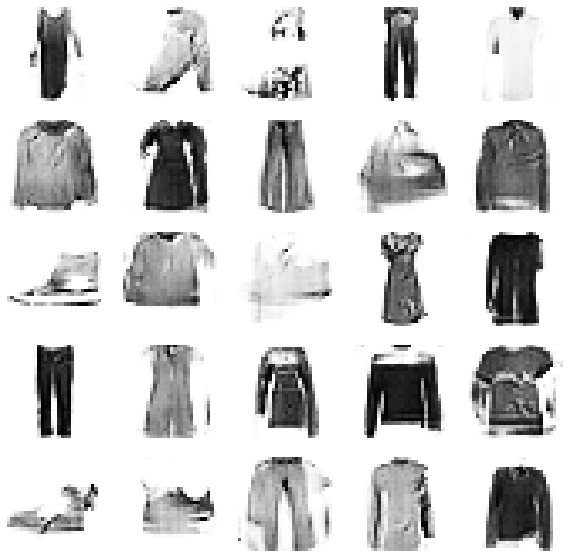

100%|██████████| 20/20 [21:38<00:00, 64.90s/it]


In [13]:
# Calling the GAN training function
train_dcgan(gan, dataset, batch_size, num_features, total_epochs = 20)